In [26]:
## loading in all of the important libraries
import os
import random
import pandas as pd
import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import tqdm as tqdm

In [86]:
## We're going to create a data loader class because this is NEEDED and I am losing it

class DataLoader():
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
    
        ## basic cleaning and processing
        self.df = self.df.drop(columns=['service_test'])
        self.balanced_df = None
        ## Combining the age bins of '60-69' and 'more than 70' into '60+' and relabeling the age bins
        self.df['age'] = self.df['age'].replace({'60-69': '60+', 'more than 70': '60+'})
        # rename Latino_Hispanic to Latino
        self.df['race'] = self.df['race'].replace({'Latino_Hispanic': 'Latino'})
        self.df = self.df.drop_duplicates(subset=['file'], keep='first')
        
        # encoding categorical labels
        age_bins = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60+']
        self.df = self.df[self.df['age'].isin(age_bins)]  # ensure only those bins are used
        
        ## these will be used to check what the encoding and decoding looks like

        self.age_encoder = LabelEncoder()
        self.df['age_label'] = self.age_encoder.fit_transform(self.df['age'])
        self.gender_encoder = LabelEncoder()
        self.df['gender_label'] = self.gender_encoder.fit_transform(self.df['gender'])
        self.race_encoder = LabelEncoder()
        self.df['race_label'] = self.race_encoder.fit_transform(self.df['race'])
        
        ## drop the original columns
        self.df = self.df.drop(['age', 'gender','race'], axis=1)

    def __print__(self):
    # function that prints the first 5 rows of the dataframe
        print(self.df.head())
        
    def __len__(self):
    # function that returns the length of the dataframe
        return len(self.df)
    
    
    def balanceAttr(self, attr_cols, n_per_group):
        # function that balances the dataset by multiple attributes
        
        state_value = np.random.randint(0, 1500) # Use numpy directly to generate a random integer
        ## I saw that using a static random state value of 0 was causing the same random sample to be generated every time
        
        grouped = self.df.groupby(attr_cols)
        self.balanced_df = grouped.apply(lambda x: x.sample(n=min(len(x), n_per_group), random_state=state_value))
        self.balanced_df = self.balanced_df.reset_index(drop=True)
        return self.balanced_df
    
    def randomizeSet(self):
        # function that randomizes the dataset
        state_value = np.random.randint(0, 1500) # Use numpy directly to generate a random integer
        self.df = (self.df).sample(frac=1, random_state=state_value).reset_index(drop=True)
    
    def randomizeBalancedSet(self):
        # function that randomizes the dataset
        state_value = np.random.randint(0, 1500) # Use numpy directly to generate a random integer
        self.tempSet = self.balanced_df.sample(frac=1, random_state=state_value).reset_index(drop=True)
        self.balanced_df = self.tempSet
    
    def displayChart(self, name):
        if name == "original":
            name = self.df
        elif name == "balanced":
            name = self.balanced_df
        else: 
            print("Please select either 'original' or 'balanced' dataset")
            return        
    
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.bar(name['age_label'].value_counts().index, name['age_label'].value_counts().values)
        plt.title('Age Distribution')
        plt.xlabel('Age Label')
        plt.ylabel('Count')

        ## count how many are label 7 and 8
        print(name['age_label'].value_counts())
        # 3270 as a combination of 7 and 8 before combinations
        # 

        ## Gender labels
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.bar(name['gender_label'].value_counts().index, name['gender_label'].value_counts().values)
        plt.title('Gender Distribution')
        plt.xlabel('Gender Label')
        plt.ylabel('Count')

        ## Race labels
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.bar(name['race_label'].value_counts().index, name['race_label'].value_counts().values)
        plt.title('Race Distribution')
        plt.xlabel('Race Label')
        plt.ylabel('Count')
        
    def getBalancedSet(self):
        return self.balanced_df
    
    def getDataSet(self):
        return self.df


C:\Users\User\AppData\Local\Temp\ipykernel_52196\1949346555.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.balanced_df = grouped.apply(lambda x: x.sample(n=min(len(x), n_per_group), random_state=state_value))


age_label
6    1400
3    1400
5    1400
1    1400
4    1400
2    1400
7    1389
0    1246
Name: count, dtype: int64


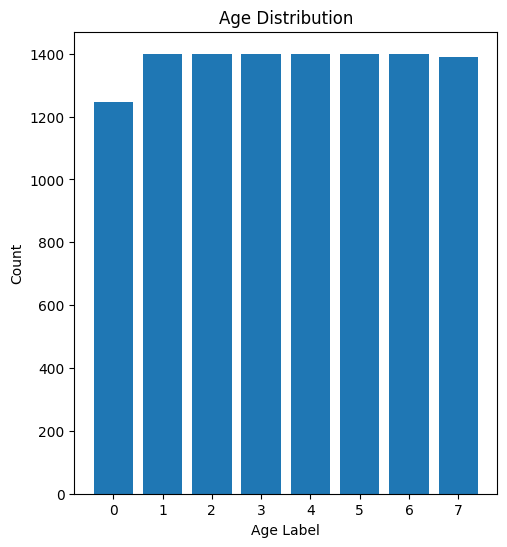

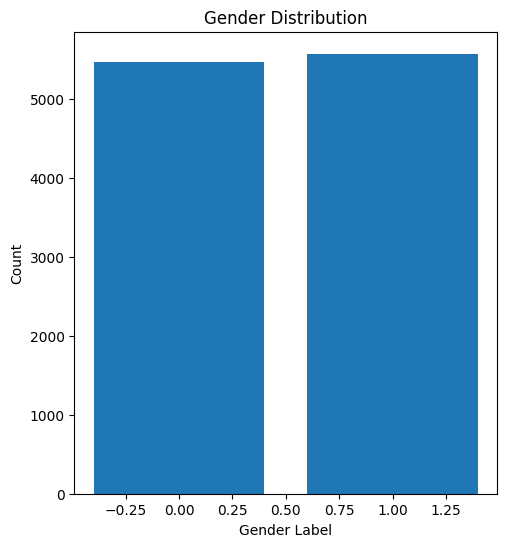

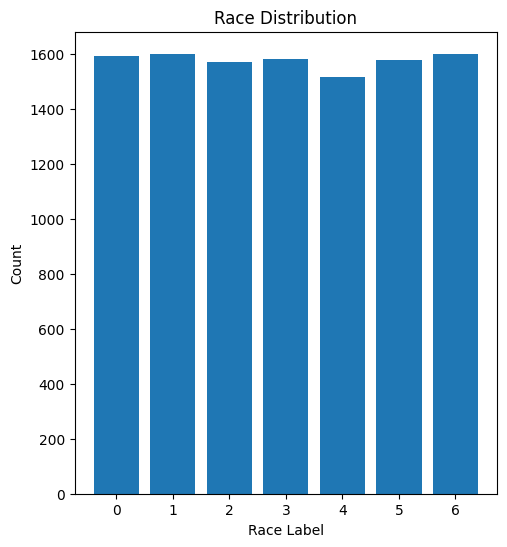

In [88]:
testSet = DataLoader('FairFace/fairface_label_train.csv')
testSet.randomizeSet()
testSet.balanceAttr(['age_label', 'gender_label', 'race_label'], 100)
# save as csv
# print(testSet.balanced_df)
testSet.randomizeBalancedSet()
testSet.displayChart("balanced")